### Import packages

In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import pickle

### Data exploration

In [2]:
df_news = pd.read_csv('news.csv')
df_news

,Unnamed: 0,date,category,text
0,0,2016-01-04 05:30:00.000000,Wirtschaft,Der Kampf gegen die Steuerflucht steht 2016 im...
1,1,2015-07-02 07:08:55.000000,Wirtschaft,Der Volltext dieses auf Agenturmeldungen basie...
2,2,2016-05-07 11:00:00.000000,Web,"Das Experiment beginnt Freitagabend, am Wochen..."
3,3,2016-05-23 09:41:27.000000,Web,"""Was waren die schlimmsten Erlebnisse, die ihr..."
4,4,2015-06-05 12:55:37.000000,Wirtschaft,Wien – Seitdem die Internationale Agentur für ...
...,...,...,...,...
5482,5482,2015-12-15 15:49:23.000000,Wissenschaft,Baikonur/London – Am frühen Dienstagabend erre...
5483,5483,2016-02-17 22:59:03.000000,Sport,Rio de Janeiro – Das Achtelfinal-Match von Dom...
5484,5484,2015-10-29 11:18:47.000000,Web,Bezahlsender Sky bringt Apps für seine hochwer...
5485,5485,2016-03-15 14:50:24.000000,Sport,Neuchatel – Nach einer neuen Studie im Auftrag...


In [3]:
df_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5487 entries, 0 to 5486
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5487 non-null   int64 
 1   date        5487 non-null   object
 2   category    5487 non-null   object
 3   text        5481 non-null   object
dtypes: int64(1), object(3)
memory usage: 171.6+ KB


In [4]:
df_news.text.isnull().sum()

6

In [5]:
# drop NaN text
df_news.dropna(inplace=True)
df_news.text.isnull().sum()

0

In [6]:
df_news.category.unique()

array(['Wirtschaft', 'Web', 'Kultur', 'Gesundheit', 'Sport',
       'Wissenschaft'], dtype=object)

#### Category distribution
we have an unbalanced dataset (see bar chart below), some solutions:

* collect more data 
* downsampling or upsampling technique (text generation)

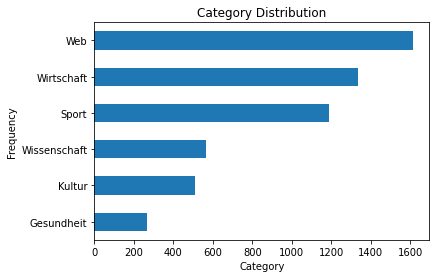

In [7]:
#category_count = pd.value_counts(df_news.category, sort=True)
df_news.category.value_counts().sort_values().plot(kind = 'barh')
#category_count.plot(kind='bar')

plt.title("Category Distribution")
plt.xlabel('Category')
plt.ylabel('Frequency')
plt.show()

In [8]:
df_news[df_news.category == 'Wirtschaft'].count()

Unnamed: 0    1335
date          1335
category      1335
text          1335
dtype: int64

### Data Preprocessing
Split data into inputs and target

In [9]:
pd.options.display.max_colwidth = 400
inputs = df_news[['text']]
inputs.head()

,text
0,"Der Kampf gegen die Steuerflucht steht 2016 im Mittelpunkt der Regierungspolitik. Dies versprach Italiens Staatspräsident Sergio Mattarella bei seiner Neujahrsansprache. Und begründete das Vorhaben damit, dass 2015 dem Fiskus 122 Milliarden Euro an Steuereinnahmen verlorengingen. Das entspricht 7,5 Prozent des Bruttoinlandprodukts (BIP). Könnte man die Steuerflucht halbieren, würden 300.000 Ar..."
1,Der Volltext dieses auf Agenturmeldungen basierenden Artikels steht aus rechtlichen Gründen nicht mehr zur Verfügung.
2,"Das Experiment beginnt Freitagabend, am Wochenende der Bundespräsidentenwahl. Einmal noch schnell ein Blick auf Twitter und Facebook, dann wird der Datenzugang am Smartphone komplett abgedreht. Um auch beim Blick auf die Uhrzeit nicht in Versuchung geführt zu werden. Die erste Herausforderung kommt bei einem Konzert. Wanda spielen in der Stadthalle. Die Fotos nicht sofort mit der Welt bzw. Fre..."
3,"""Was waren die schlimmsten Erlebnisse, die ihr als IT-Mitarbeiter erlebt habt?"" Diese einfache Frage hat auf Reddit zu einer Myriade von Anekdoten geführt. Die Webseite ""Knowable"" hat sich nun die absurdesten Fälle herausgesucht und in einem Artikel zusammengefasst – der zeigt, wie weit verbreitet manche extreme Formen von ""IT-Analphabetismus"" tatsächlich sind. So erzählt ein Nutzer, dass ein ..."
4,"Wien – Seitdem die Internationale Agentur für Krebsforschung der WHO (Weltgesundheitsorganisation) im April eine neue Studie vorgestellt hat, ist in Sachen Unkrautvernichtungsmittel Feuer am Dach. Glyphosat, das weltweit am häufigsten eingesetzte Pestizid, wird darin als ""wahrscheinlich krebserregend"" eingestuft. Diejenigen Personen, die mit dem Pestizid in Berührung kommen, haben ein erh..."


In [10]:
inputs.iloc[4]

text    Wien – Seitdem die Internationale Agentur für Krebsforschung der WHO  (Weltgesundheitsorganisation) im April eine neue Studie vorgestellt hat,  ist in Sachen Unkrautvernichtungsmittel Feuer am Dach. Glyphosat, das  weltweit am häufigsten eingesetzte Pestizid, wird darin als  "wahrscheinlich krebserregend" eingestuft. Diejenigen Personen, die mit  dem Pestizid in Berührung kommen, haben ein erh...
Name: 4, dtype: object

#### clean the text data
* lowercase
* ponctuation
* numbers
* special characters
* (maybe, stop words also)

We will make the assumption that these characters are not useful for the text classfication task 

In [11]:
import re # use regular expression
import string

def clean_text(text):
    text = text.lower() # lowercase 
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # ponctuation
    text = re.sub('\d', '', text) # numbers
    text = re.sub('[''–’-“”_]', '', text) # special character
    text = re.sub('\n', '', text) # new line
    return text

inputs_clean = pd.DataFrame(
            inputs.text.apply(lambda x: clean_text(x))
)

In [12]:
inputs_clean.head()

,text
0,der kampf gegen die steuerflucht steht im mittelpunkt der regierungspolitik dies versprach italiens staatspräsident sergio mattarella bei seiner neujahrsansprache und begründete das vorhaben damit dass dem fiskus milliarden euro an steuereinnahmen verlorengingen das entspricht prozent des bruttoinlandprodukts bip könnte man die steuerflucht halbieren würden arbeitsplätze mehr geschaffen w...
1,der volltext dieses auf agenturmeldungen basierenden artikels steht aus rechtlichen gründen nicht mehr zur verfügung
2,das experiment beginnt freitagabend am wochenende der bundespräsidentenwahl einmal noch schnell ein blick auf twitter und facebook dann wird der datenzugang am smartphone komplett abgedreht um auch beim blick auf die uhrzeit nicht in versuchung geführt zu werden die erste herausforderung kommt bei einem konzert wanda spielen in der stadthalle die fotos nicht sofort mit der welt bzw freunden un...
3,was waren die schlimmsten erlebnisse die ihr als itmitarbeiter erlebt habt diese einfache frage hat auf reddit zu einer myriade von anekdoten geführt die webseite knowable hat sich nun die absurdesten fälle herausgesucht und in einem artikel zusammengefasst der zeigt wie weit verbreitet manche extreme formen von itanalphabetismus tatsächlich sind so erzählt ein nutzer dass ein kollege ihm von...
4,wien seitdem die internationale agentur für krebsforschung der who weltgesundheitsorganisation im april eine neue studie vorgestellt hat ist in sachen unkrautvernichtungsmittel feuer am dach glyphosat das weltweit am häufigsten eingesetzte pestizid wird darin als wahrscheinlich krebserregend eingestuft diejenigen personen die mit dem pestizid in berührung kommen haben ein erhöhtes risiko...


#### transform target data (one hot encoding)

In [13]:
target = np.array(df_news['category'].values)
print(target.shape)
print(target[:10])

(5481,)
['Wirtschaft' 'Wirtschaft' 'Web' 'Web' 'Wirtschaft' 'Kultur' 'Gesundheit'
 'Sport' 'Sport' 'Sport']


In [14]:
i = 0
target_dict = {}
for category in df_news.category.unique():
    target_dict[category] = i
    i+=1
print(target_dict)

# one hot encoding
target_enc = np.zeros((len(target), len(np.unique(target))), dtype='int')
for i, category in enumerate(target):
    target_enc[i, target_dict[category]] = 1
print(target_enc.shape)
print(target_enc[:10])

{'Wirtschaft': 0, 'Web': 1, 'Kultur': 2, 'Gesundheit': 3, 'Sport': 4, 'Wissenschaft': 5}
(5481, 6)
[[1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]]


#### Word Indexing
use the TextVectorization form Keras to index the vocabulary found in the dataset.

In [15]:
text_array = np.array(inputs_clean.values) 
print(text_array.shape)
print(text_array[1])

(5481, 1)
['der volltext dieses auf agenturmeldungen basierenden artikels steht aus rechtlichen gründen nicht mehr zur verfügung']


consider the top 20,000 words. Truncate or pad sequences to be actually 200 tokens long.

In [16]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
vectorizer.adapt(text_array)

In [17]:
# top words - too many die, der, und
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'die', 'der', 'und']

In [18]:
output = vectorizer([["Ich beschäftige mich mit data science"]])
output.numpy()[0, :6]

array([   54, 16020,   231,     9,  4702,  1766])

#### remove stop words: die, der, und etc.

In [19]:
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer

stop = set(stopwords.words('german'))
def remove_stop_words(data):
    for i, sentence in enumerate(data):
        sentence_without_stops = [i for i in word_tokenize(sentence[0].lower()) 
                                  if i not in stop]
        sent = [TreebankWordDetokenizer().detokenize(sentence_without_stops)]
        data[i] = sent
    return data

In [20]:
text_array = remove_stop_words(text_array)
print(text_array[1])

['volltext agenturmeldungen basierenden artikels steht rechtlichen gründen mehr verfügung']


In [21]:
# index without stop words
max_tokens = 20000
output_sequence_length = 500
vectorizer = TextVectorization(max_tokens=max_tokens,
                               output_sequence_length=output_sequence_length)
vectorizer.adapt(text_array)

In [22]:
vectorizer.get_vocabulary()[:5]

['', '[UNK]', 'mehr', 'prozent', 'wurde']

In [23]:
output = vectorizer([["liebe data science"]])
output.numpy()[0, :6]

array([ 986, 4509, 1587,    0,    0,    0])

In [24]:
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

In [25]:
test = ["liebe", "data", "science"]
[word_index[w] for w in test] 

[986, 4509, 1587]

#### create train, validation and test set

In [26]:
train_X, test_X, train_Y, test_Y = train_test_split(text_array, target_enc,
                                                   test_size=0.1)
X, val_X, Y, val_Y = train_test_split(train_X, train_Y, test_size=0.1)
print("X shape : {}, Y shape: {}".format(X.shape, Y.shape))
print("val_X shape : {}, val_Y shape: {}".format(val_X.shape, val_Y.shape))
print("test_X shape : {}, test_Y shape: {}".format(test_X.shape, test_Y.shape))

X shape : (4438, 1), Y shape: (4438, 6)
val_X shape : (494, 1), val_Y shape: (494, 6)
test_X shape : (549, 1), test_Y shape: (549, 6)


### Build the model

In [27]:
from tensorflow.keras import layers, Input

embedding_dim = 200

input_int = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = layers.Embedding(max_tokens, embedding_dim)(input_int)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(df_news.category.unique()),
                       activation="softmax")(x)
model = keras.Model(input_int, outputs)
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 200)         4000000   
_________________________________________________________________
conv1d (Conv1D)              (None, None, 128)         128128    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 128)         0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 128)         82048     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, None, 128)         0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, None, 128)        

In [28]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [29]:
X.shape

(4438, 1)

In [30]:
x_train = vectorizer(X).numpy()
x_val = vectorizer(val_X).numpy()
x_test = vectorizer(test_X).numpy()

y_train = np.array(Y)
y_val = np.array(val_Y)
y_test = np.array(test_Y)

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

(4438, 500)
(494, 500)
(549, 500)


In [31]:
print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(4438, 500) (4438, 6)
(494, 500) (494, 6)


In [32]:
print(x_train[2])

[    1    99   100  1233    49   197     1   780  5829   309     1  1261
   145     1  1762  2810    47   644   128  8981  8425   374   122   208
  3900 10440 15776  9017    14  9231   726     1  1482  3546     1  2270
    84  1224   211  1278  4613     1    72    49  1377  3791   864   729
     1   937   454  2335   186  8146  7063   166  3049     1  7064  9607
     7   669   241  5993   507   208     1  1037   437   159  1371  1037
  3894   322 10070     1  4099   143  7063    21  2639 16257     1    71
     1     1   125 15776  1937    40     8   254   126   566   441   726
     1   972     1  7252   218  5544   374     1   114     1   162   951
   104   216     1   729     1  1543    57  1648    42     1   145   101
   780  5829   309   878    46  1358   626  1478  8057 13812   199   503
   132    11     1   145     1   211  4362     1 11491  1762  2810   972
   211     1     1  4234    47   644   128  2955   117  1564   337     0
     0     0     0     0     0     0     0     0   

### Train the model

In [33]:
history = model.fit(x_train, y_train, 
          batch_size=128, epochs=8,
          validation_data=(x_val, y_val))

Epoch 1/8
35/35 [==============================] - 40s 1s/step - loss: 1.6555 - accuracy: 0.2803 - val_loss: 1.5343 - val_accuracy: 0.3320
Epoch 2/8
35/35 [==============================] - 33s 939ms/step - loss: 1.2160 - accuracy: 0.4626 - val_loss: 0.7104 - val_accuracy: 0.7146
Epoch 3/8
35/35 [==============================] - 35s 1s/step - loss: 0.5364 - accuracy: 0.7751 - val_loss: 0.6311 - val_accuracy: 0.7814
Epoch 4/8
35/35 [==============================] - 34s 974ms/step - loss: 0.2887 - accuracy: 0.8855 - val_loss: 0.5890 - val_accuracy: 0.8198
Epoch 5/8
35/35 [==============================] - 33s 938ms/step - loss: 0.1556 - accuracy: 0.9439 - val_loss: 0.6412 - val_accuracy: 0.8340
Epoch 6/8
35/35 [==============================] - 34s 972ms/step - loss: 0.0654 - accuracy: 0.9802 - val_loss: 0.6185 - val_accuracy: 0.8623
Epoch 7/8
35/35 [==============================] - 33s 941ms/step - loss: 0.0298 - accuracy: 0.9908 - val_loss: 0.7441 - val_accuracy: 0.8522
Epoch 8/8
35

### Prediction
Overfitting problem --> should the model with less epochs

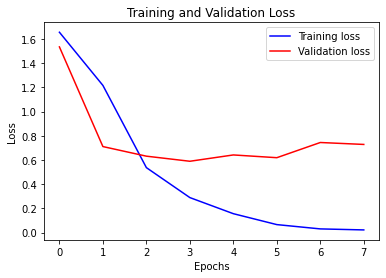

In [34]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

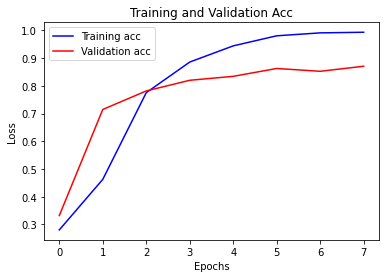

In [35]:
def visualize_acc(history, title):
    loss = history.history["accuracy"]
    val_loss = history.history["val_accuracy"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training acc")
    plt.plot(epochs, val_loss, "r", label="Validation acc")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_acc(history, "Training and Validation Acc")

In [36]:
predictions = model.predict(x_test)
pred = np.argmax(predictions, axis=1)
true = np.argmax(y_test, axis=1)
print("accuracy test set : ", (pred == true).sum() / len(true))

accuracy test set :  0.8561020036429873


In [37]:
text = np.array(["dieser Text ist über Geld und Wirtschaft", "die Korona hat unsere Gesundheit verschlechert",
                 "Volltext dieses auf Agenturmeldungen basierenden Artikels steht aus rechtlichen",
                 "Menschen sterben heutzutage jeden Tag", "Real Madrid hat das Champions League wieder gewonnen",
                 "Politiker sind nicht gut", "Bewerbungen für Data Science Stellen sind nicht viele"])
text.shape

(7,)

In [38]:
text = text.tolist()
text = np.array([clean_text(x) for x in text])
text = remove_stop_words(text.reshape(-1, 1))
text

array([['text geld wirtschaft'],
       ['korona gesundheit verschlechert'],
       ['volltext agenturmeldungen basierenden artikels steht rechtlichen'],
       ['menschen sterben heutzutage tag'],
       ['real madrid champions league gewonnen'],
       ['politiker gut'],
       ['bewerbungen data science stellen viele']], dtype='<U79')

In [39]:
text_vec = vectorizer(text).numpy()

In [40]:
text_vec.shape

(7, 500)

In [41]:
one_hot_to_label_dict = {}
for key, value in target_dict.items():
    one_hot_to_label_dict[value] = key

In [42]:
print(one_hot_to_label_dict)

{0: 'Wirtschaft', 1: 'Web', 2: 'Kultur', 3: 'Gesundheit', 4: 'Sport', 5: 'Wissenschaft'}


In [43]:
predi = model.predict(text_vec)
print(predi.shape)
pred_index = np.argmax(predi, axis=1)
for elem in pred_index:
    print(one_hot_to_label_dict[elem])

(7, 6)
Kultur
Gesundheit
Wirtschaft
Wissenschaft
Sport
Wissenschaft
Wissenschaft


In [44]:
input_str = keras.Input(shape=(1,), dtype="string")
x = vectorizer(input_str)
output_str = model(x)

model_str = keras.Model(input_str, output_str)
model_str.compile(loss='binary_crossentropy', optimizer='adam',
              metrics=['accuracy'])

In [45]:
predi_str = model_str.predict(text)
print(predi_str.shape)
pred_str_index = np.argmax(predi_str, axis=1)
for elem in pred_str_index:
    print(one_hot_to_label_dict[elem])

(7, 6)
Kultur
Gesundheit
Wirtschaft
Wissenschaft
Sport
Wissenschaft
Wissenschaft
